# Import the necessary pacakges

In [1]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import cv2

import matplotlib.pyplot as plt
%matplotlib inline

## Global variables

In [2]:
IMG_SHAPE = [192, 256]

BUFFER_SIZE = 1000
BATCH_SIZE = 32

INPUT_CHANNELS = 3
OUTPUT_CHANNELS = 13

In [3]:
def display_images(images, titles=None, plot_title=None, size=(15, 10), grayscale=False):
    """
    Display a list of images using matplotlib.pyplot.
    
    Parameters:
    images (list): A list of images to display.
    titles (list): A list of titles for each image in `images`.
    plot_title (str): A title for the whole plot.
    """
    
    if titles is None:
        titles = [f"Image {i + 1}" for i in range(len(images))]

    if plot_title is None:
        plot_title = "Images"

    fig, axs = plt.subplots(1, len(images), figsize=size)
    
    for i, (img, title) in enumerate(zip(images, titles)):
        axs[i].imshow(img, cmap='gray' if grayscale else None)
        axs[i].axis('off')
        axs[i].set_title(title)
    
    fig.suptitle(plot_title if plot_title is not False else None, fontsize=20)
    plt.show()

In [4]:
def load_image(im_path):
    """
    Load an image from the given file path and convert it from BGR color space to RGB color space.

    Parameters:
    im_path (str): The file path of the image to be loaded.

    Returns:
    numpy.ndarray: The loaded image in RGB color space.
    """
    return cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2RGB)

In [5]:
def create_mask(pred):
    """
    Create a mask from a given prediction tensor.

    Parameters:
    pred (numpy.ndarray or tensorflow.Tensor): A 3D or 4D tensor of predictions.

    Returns:
    numpy.ndarray: A mask of the same shape as the input tensor.
    """
    mask = tf.argmax(pred, axis=-1)
    mask = np.array(mask[..., tf.newaxis])
    return mask

In [6]:
def get_predictions(model, images):
    """
    Generate masks for a list of input images using a deep learning model.

    Parameters:
    model (tensorflow.keras.Model): A deep learning model to use for prediction.
    images (list of str): A list of images to generate masks for.

    Returns:
    list of numpy.ndarray: A list of masks corresponding to the input images.
    """
    pred = model.predict(images)

    pred = [create_mask(p) for p in pred]

    return pred

# Load the dataset

In [7]:
folders = ["A", "B", "C", "D", "E"]

image_folders = [f'/kaggle/input/lyft-udacity-challenge/data{f}/data{f}/CameraRGB/' for f in folders]
mask_folders = [f'/kaggle/input/lyft-udacity-challenge/data{f}/data{f}/CameraSeg/' for f in folders]

all_images = [os.path.join(folder, image) for folder in image_folders for image in os.listdir(folder)]
all_masks = [os.path.join(folder, image) for folder in mask_folders for image in os.listdir(folder)]

print(len(np.unique(all_images)))

assert len(all_images) == 5000
assert len(all_masks) == 5000

5000


In [8]:
for img in np.random.choice(all_images, 10, replace=False):
    image = load_image(img)
    print("Image shape {}".format(image.shape))

Image shape (600, 800, 3)
Image shape (600, 800, 3)
Image shape (600, 800, 3)
Image shape (600, 800, 3)
Image shape (600, 800, 3)
Image shape (600, 800, 3)
Image shape (600, 800, 3)
Image shape (600, 800, 3)
Image shape (600, 800, 3)
Image shape (600, 800, 3)


In [9]:
for mask in np.random.choice(all_images, 10):
    mask = load_image(img)
    print("Mask shape {}".format(mask.shape))

Mask shape (600, 800, 3)
Mask shape (600, 800, 3)
Mask shape (600, 800, 3)
Mask shape (600, 800, 3)
Mask shape (600, 800, 3)
Mask shape (600, 800, 3)
Mask shape (600, 800, 3)
Mask shape (600, 800, 3)
Mask shape (600, 800, 3)
Mask shape (600, 800, 3)


In [10]:
image_list_ds = tf.data.Dataset.list_files(all_images, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(all_masks, shuffle=False)

full_ds = tf.data.Dataset.zip((image_list_ds, mask_list_ds))

for i, m in full_ds.take(2):
    print(i)
    print(m)

tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_000.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraRGB/02_00_001.png', shape=(), dtype=string)
tf.Tensor(b'/kaggle/input/lyft-udacity-challenge/dataA/dataA/CameraSeg/02_00_001.png', shape=(), dtype=string)


# Preprocessing

In [11]:
def preprocess(image, mask):
    input_image = tf.image.resize(image, IMG_SHAPE, method='nearest')
    input_mask = tf.image.resize(mask, IMG_SHAPE, method='nearest')

    return input_image, input_mask

def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    
    img, mask = preprocess(img, mask)
    
    return img, mask

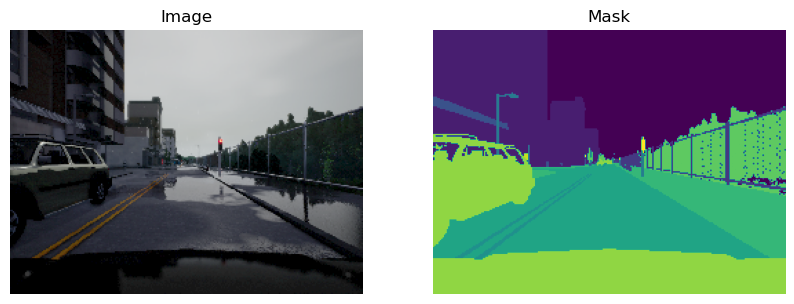

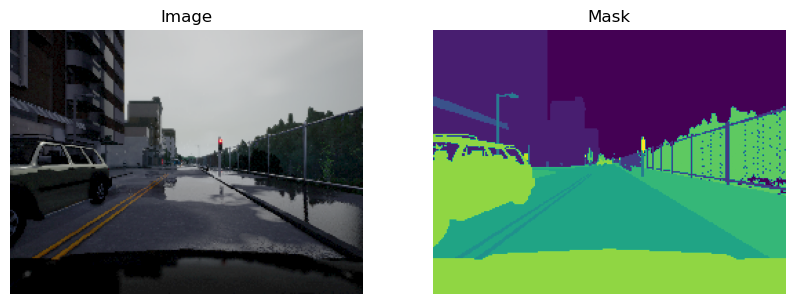

In [12]:
image_ds = full_ds.map(process_path)

for img, mask in image_ds.take(2):
    display_images([img, mask], titles=["Image", "Mask"], plot_title=False, size=(10, 10))

In [13]:
uniques = set()

for img, mask in image_ds.take(5000):
    uniques.update(np.unique(mask.numpy()))
    
uniques

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}

# Split into train, val, test dataset

In [14]:
train_size = .7
val_size = .2
test_size = .1

ds_size = tf.data.experimental.cardinality(image_ds).numpy()

train_size = int(ds_size * train_size)
val_size = int(ds_size * val_size)
test_size = int(ds_size * test_size)

print("""Train size: {}
Val size: {}
Test size: {}""".format(train_size, val_size, test_size))

Train size: 3500
Val size: 1000
Test size: 500


In [15]:
image_ds = image_ds.shuffle(BUFFER_SIZE)

train_ds = image_ds.take(train_size)
val_ds = image_ds.skip(train_size).take(val_size)
test_ds = image_ds.skip(train_size).skip(val_size)

print("""Train size: {}
Val size: {}
Test size: {}""".format(tf.data.experimental.cardinality(train_ds).numpy(), 
                        tf.data.experimental.cardinality(val_ds).numpy(), 
                        tf.data.experimental.cardinality(test_ds).numpy()))

Train size: 3500
Val size: 1000
Test size: 500


# Define the model
I use the following functions to build the model:

In [16]:
def downsample(filters, size, strides=(2, 2), apply_norm=True):
    # Conv2D => LeakyRelu => Conv2D => Batchnorm => LeakyRelu

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(
          filters, size, padding='same',
          kernel_initializer=initializer, use_bias=False,
          strides=strides
      )
    )

    result.add(tf.keras.layers.LeakyReLU())
    
    result.add(
      tf.keras.layers.Conv2D(
          filters, size, padding='same',
          kernel_initializer=initializer, use_bias=False,
      )
    )
    
    if apply_norm:
        result.add(tf.keras.layers.BatchNormalization())
        
    result.add(tf.keras.layers.LeakyReLU())
    
    return result

def upsample(filters, size, apply_dropout=False):
    # Conv2DTranspose => Batchnorm => RelU => Conv2D => Dropout => Batchnorm => Relu

    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))
    
    result.add(tf.keras.layers.BatchNormalization())
      
    result.add(tf.keras.layers.ReLU())
      
    result.add(
      tf.keras.layers.Conv2D(
          filters, size, padding='same',
          kernel_initializer=initializer, use_bias=False,
      )
    )
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
        
    result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.ReLU())

    return result

In [17]:
down_stack = [
    downsample(32, 4, apply_norm=False),
    downsample(64, 4),
    downsample(128, 4),
    downsample(256, 4),
    downsample(512, 4),
    # downsample(512, 4),
    # downsample(512, 4),
    # downsample(512, 4)
]

up_stack = [
    # upsample(512, 4, apply_dropout=True),
    # upsample(512, 4, apply_dropout=True),
    # upsample(512, 4, apply_dropout=True),
    upsample(256, 4, apply_dropout=True),
    upsample(128, 4, apply_dropout=True),
    upsample(64, 4, apply_dropout=True),
    upsample(32, 4, apply_dropout=True),
]

initializer = tf.random_normal_initializer(0., 0.02)

input = tf.keras.layers.Input(shape=IMG_SHAPE + [INPUT_CHANNELS])

concat = tf.keras.layers.Concatenate(axis=3)

skips = []

x = input

for down in down_stack:
    x = down(x)
    skips.append(x)

skips = reversed(skips[:-1])

for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])
    
last = Conv2DTranspose(32,
             4,
             strides=2,
             activation='relu',
             padding='same',
             kernel_initializer='he_normal')(x)

# last layer, a 1d convolution that outputs actual class prediction
last = Conv2D(OUTPUT_CHANNELS, 1, strides=1, padding='same')(last)

x = last

model = tf.keras.Model(inputs=input, outputs=x)

# i used the Adam optimizer and SparseCategoricalCrossentropy loss (important to set from_logits to True, as our model outputs logits)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics='accuracy'
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 96, 128, 32)  17920       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 48, 64, 64)   98560       ['sequential[0][0]']             
                                                                                                  
 sequential_2 (Sequential)      (None, 24, 32, 128)  393728      ['sequential_1[0][0]']       

# Train the model
Train the model on train set, using val for validation.

Batch size is 32.

10 epochs at a time

In [18]:
EPOCHS = 20
BATCH_SIZE = 32

train_ds_b = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds_b = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

model_history = model.fit(train_ds_b, validation_data=val_ds_b, epochs=EPOCHS)

Epoch 1/20


2023-05-01 18:32:10.859772: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_5/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 188s 1s/step - loss: 0.9854 - accuracy: 0.6823 - val_loss: 1.5333 - val_accuracy: 0.7070
Epoch 2/20
110/110 [==============================] - 22s 204ms/step - loss: 0.4625 - accuracy: 0.8574 - val_loss: 1.1030 - val_accuracy: 0.7853
Epoch 3/20
110/110 [==============================] - 22s 198ms/step - loss: 0.3561 - accuracy: 0.8910 - val_loss: 0.3818 - val_accuracy: 0.8843
Epoch 4/20
110/110 [==============================] - 22s 197ms/step - loss: 0.2921 - accuracy: 0.9094 - val_loss: 0.3843 - val_accuracy: 0.8807
Epoch 5/20
110/110 [==============================] - 22s 204ms/step - loss: 0.2609 - accuracy: 0.9180 - val_loss: 0.3430 - val_accuracy: 0.8930
Epoch 6/20
110/110 [==============================] - 22s 198ms/step - loss: 0.2306 - accuracy: 0.9270 - val_loss: 0.4341 - val_accuracy: 0.8689
Epoch 7/20
110/110 [==============================] - 22s 198ms/step - loss: 0.2127 - accuracy: 0.9324 - val_loss: 0.2438 - val_accuracy: 0.922

# Evaluate the model

In [19]:
test_ds_b = test_ds.batch(4).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

model.evaluate(test_ds_b)

125/125 [==============================] - 88s 14ms/step - loss: 0.1514 - accuracy: 0.9558


[0.15137626230716705, 0.9558078646659851]

In [20]:
images = []
true_masks = []

for im, mask in test_ds.take(5):
    images.append(im.numpy())
    true_masks.append(mask.numpy())

In [21]:
pred = get_predictions(model, np.array(images))

1/1 [==============================] - 0s 479ms/step


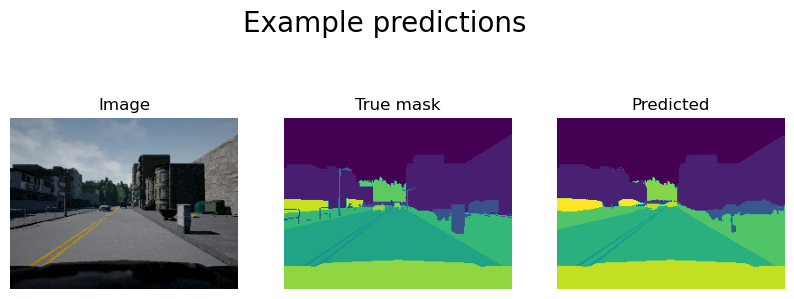

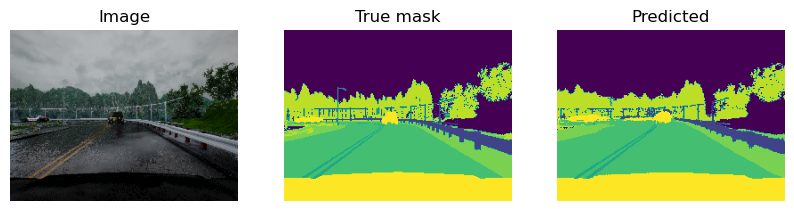

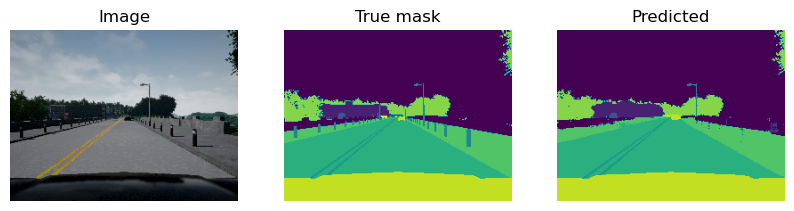

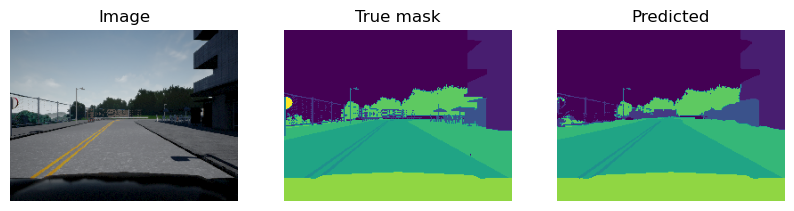

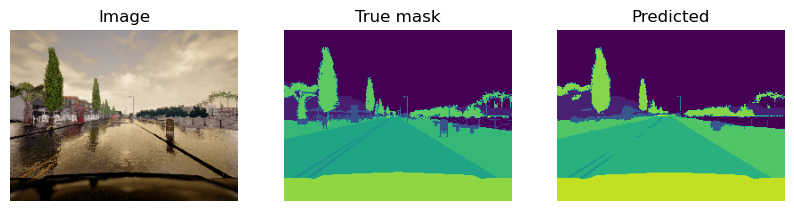

In [22]:
first = True

for im, true, pred in zip(images, true_masks, pred):
    display_images([im, true, pred], size=(10, 4), plot_title="Example predictions" if first else False, titles=("Image", "True mask", "Predicted"))
    first = False